# Eda y Preparacion de los Datos


## **Carga de Librerias y dataset**

In [1]:
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

df_games = pd.read_csv('./server/pkl/steam_games_PI.csv', index_col=[0])
df_games.head(5)

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",4.49,http://steamcommunity.com/app/761140/reviews/?...,['Single-player'],4.99,False,761140.0,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free To Play,False,643980.0,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"['Free to Play', 'Simulation', 'Sports', 'Casu...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free to Play,False,670290.0,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"['Action', 'Adventure', 'Casual']",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"['Action', 'Adventure', 'Casual']",0.83,http://steamcommunity.com/app/767400/reviews/?...,['Single-player'],0.99,False,767400.0,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"['Action', 'Indie', 'Casual', 'Sports']",1.79,http://steamcommunity.com/app/773570/reviews/?...,"['Single-player', 'Full controller support', '...",2.99,False,773570.0,NaN,NaN,NaN


### **Consideraciones**

De acuerdo a a previsualización anterioir, la gran parte de los datos corersponden a dato valores, os cuales, por Lotanto, antes de realziar el modelo, se prevee una dificultad para que el modelo sea preciso, puesto que no hay variable

El Modleo de prediccion de preciso da como inputs valores numericos continuos, y para poder obtener un modelo preciso, se rquiere el entrenamientos de variables continuas numericas qeu vayan correlaccionas con el precio. En cambio, se disponen de variables categoricas, las cuales podrian definir diferentes rangos de percios, pero no explciar.

Es por ello, que se deberá aprovechar a maximo la obtencion de variables numericas que una correlacion linela.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Utilidades**

Dentro del archivo utils, se encuentran una serie de funciones que fueron utuilidas para la transformacion de datos

In [16]:
from sklearn import preprocessing
from ast import literal_eval

def label_encode_columns(df, columns):
    """
    Esta funcion recibe un dataframe y hace un label encoding
    """
    encoding_dict = {}
    for col in columns:
        le = preprocessing.LabelEncoder()
        df[col] = le.fit_transform(df[col])
        encoding_dict[col] = dict(zip(le.classes_, le.transform(le.classes_)))
    return encoding_dict

def get_list_elements(df, column):
    df = df.copy()
    elements_dict = {}

    def read_list(el_list):
        if isinstance(el_list, str):
            for el in list(literal_eval(el_list)):
                if el in elements_dict :
                    elements_dict[el] += 1
                else:
                    elements_dict[el] = 1

    df[column].map(lambda x: read_list(x))
    return elements_dict

def element_in_list(list_str, tag):
    if isinstance(list_str, str):
        list_str = list(literal_eval(list_str))
        if tag in list_str :
            return 1
        else:
            return 0
    else:
        return 0

def tag_to_hot_encoding(df, column, tag):
    df[tag] = df[column].map(lambda el_list: element_in_list(el_list, tag))

def delete_row_by_tag(df, list_column, tags):

  def read_list(el_list):
    if isinstance(el_list, str):
      list_of_tags = list(literal_eval(el_list))
      for tag in tags:
        if tag in list_of_tags:
          return True
    return False

  df['is_deleted'] = df[list_column].map(lambda x: read_list(x))
  df = df[~df['is_deleted']]
  df = df.drop(['is_deleted'], axis=1)

def create_column_tags(df, list_column, new_column, tags):

  def read_list(el_list):
    if isinstance(el_list, str):
      list_of_tags = list(literal_eval(el_list))
      for tag in tags:
        if tag in list_of_tags:
          return 1
    return 0

  df[new_column] = df[list_column].map(lambda x: read_list(x))

def number_of_items(df, list_column):

  def read_list(el_list):
    if isinstance(el_list, str):
      list_of_tags = list(literal_eval(el_list))
      return len(list_of_tags)
    return 0

  column_name = 'Number_of_' + list_column
  df[column_name] = df[list_column].map(lambda x: read_list(x))

## **Columnas Innecesarias**

La idea del modelo, es que logre predecir el precio en base a la caracteristicas tenicas propias del videojuegos: como el genero, las especficaciones, el año del lanazamiento.Se consideraron incesasarias las siguientes columnas:

- Url
- Reviews_url
- Developer
- Discount_price
- Publisher
- Id
- App_name
- Title

In [4]:
cols_to_drop = [
  'url',
  'reviews_url',
  'developer',
  'discount_price',
  'publisher',
  'id',
  'app_name',
  'title'
]

df_games = df_games.dropna(subset=['metascore',])
df_games = df_games.drop(cols_to_drop, axis=1)

## **Valores Nulos y Duplicados**

Habiendo hecho la seleccion previa de la muestra del dataset, los valores se distribuyeron de la siguiente manera.

In [5]:
df_games.isna().sum()


genres          62
release_date    54
tags             1
specs            4
price           23
early_access     0
sentiment       21
metascore        0
dtype: int64

In [6]:
df_games.dropna()
df_games.drop_duplicates()

,genres,release_date,tags,specs,price,early_access,sentiment,metascore
28,['Action'],1998-11-08,"['FPS', 'Classic', 'Action', 'Sci-fi', 'Single...","['Single-player', 'Multi-player', 'Valve Anti-...",9.99,False,Overwhelmingly Positive,96.0
39,['Strategy'],2006-07-06,"['Turn-Based Strategy', 'Strategy', 'Classic',...","['Single-player', 'Multi-player', 'Co-op']",6.99,False,Mostly Positive,84.0
40,['Strategy'],2006-07-06,"['Strategy', 'Turn-Based Strategy', 'Fantasy',...","['Single-player', 'Multi-player', 'Co-op']",6.99,False,Very Positive,80.0
41,"['Action', 'Indie', 'RPG']",2006-07-11,"['Multiplayer', 'Indie', 'Action', 'First-Pers...","['Single-player', 'Multi-player', 'Steam Tradi...",9.99,False,Very Positive,76.0
55,['Action'],2005-08-09,"['Action', 'Sci-fi', 'Story Rich', 'Singleplay...","['Single-player', 'Steam Trading Cards']",9.99,False,Mostly Positive,70.0
...,...,...,...,...,...,...,...,...
32109,['Action'],2001-06-01,"['FPS', 'Action', 'Sci-fi', 'Singleplayer', 'S...",['Single-player'],4.99,False,Very Positive,71.0
32112,"['Action', 'Adventure']",2002-08-28,"['Action', 'Adventure', 'Violent', 'Story Rich...",['Single-player'],14.99,False,Overwhelmingly Positive,88.0
32114,['Action'],2003-05-01,"['FPS', 'World War II', 'Multiplayer', 'Action...","['Multi-player', 'Valve Anti-Cheat enabled']",4.99,False,Very Positive,79.0
32116,['Action'],2004-03-16,"['FPS', 'Arena Shooter', 'Action', 'Classic', ...","['Single-player', 'Multi-player', 'Steam Tradi...",14.99,False,Overwhelmingly Positive,93.0


Eb estos, casos, las columnas en price y release_data se consideraron de especial relevancia puesto qeu una es el valor objetivo y la otra representa uma de las pocas varialbes numericsa que se disponen.

In [7]:
# Fechas de lanzamiento
df_games['release_date'] = pd.to_datetime(df_games['release_date'], errors='coerce').dt.year
df_games = df_games.dropna(subset=['release_date']).copy()
df_games['release_date'] = df_games['release_date'].astype('int')

# Precios
df_games['price'] = pd.to_numeric(df_games['price'], errors='coerce').copy()
df_games = df_games.dropna(subset=['price']).copy()
df_games['release_date'] = df_games['release_date'].astype('int').copy()

Cabe resaltar, que en la columna price existe una gran cantidad de categorias , pero este tipo de dato no representa una aproximacion, si no una actegoria que define a un juego como gratis. Es por ello, que ningun gratutito fue incluido dentro del analisis, y en cambio, en el desarrollo de la Api, se aclaro que el modelo solo funciona con modelos, por que se sobreentiende que el precio es 0 en caso de ser Free To Play

## **Outliers**

Del dataset, solo se dispone de tres variables numericas a las cuales se le puede verficar el

<Axes: xlabel='price'>

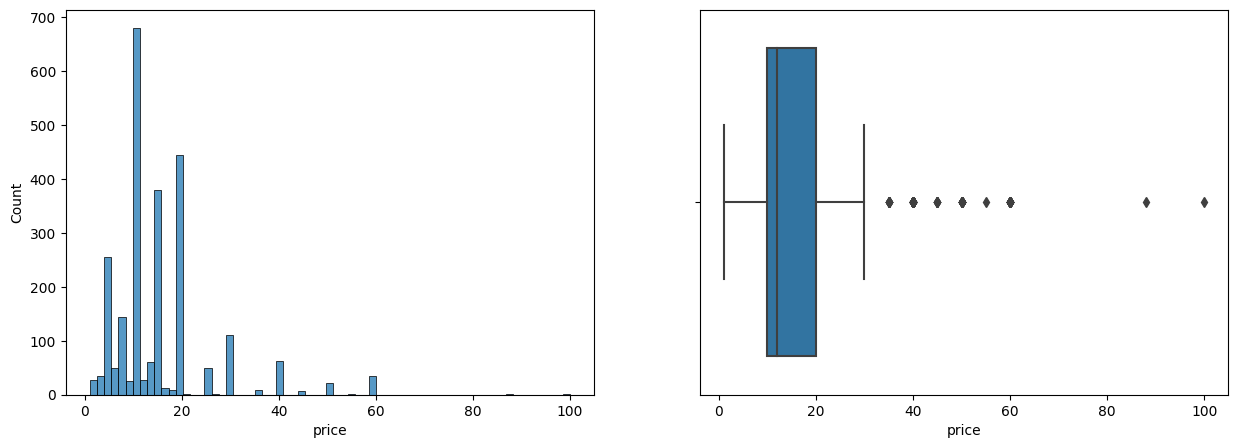

In [9]:
fig, ax = plt.subplots(1, 2,figsize=(15,5))

sns.histplot(ax=ax[0], data=df_games, x='price')
sns.boxplot(ax=ax[1], data=df_games, x='price')

Viendo los graficos, se puede ver como la distribucion de juegos esta presntre ente un rango entre los 2 doalres y 20. Lo mismo ocurre, en donde todos lso videojuegospor encima de 20 son considerados outliers.

en este caso particular, solo le eliminaran los registros que esten por encima de 60 dolares. Peor la asucencia de juegos por encima de 20, podria ocasionar que el modelo mas impreciso, en rangos de precios por no tener muestrs con las cuales entrenar.

In [10]:
df_games = df_games[df_games['price'] < 60]

Para el resto de variables categoriaas

## **Precio**

## **Variables Categoricas**

## **Sentimiento**

In [12]:
df_games.groupby('sentiment')['sentiment'].count()

sentiment
1 user reviews               10
2 user reviews                9
3 user reviews                7
4 user reviews                6
5 user reviews                6
6 user reviews                7
7 user reviews                9
8 user reviews                9
9 user reviews                7
Mixed                       483
Mostly Negative              50
Mostly Positive             458
Negative                      3
Overwhelmingly Negative       2
Overwhelmingly Positive     163
Positive                    118
Very Negative                 4
Very Positive              1077
Name: sentiment, dtype: int64

Como exisen sentimiento, que representan un numero de n reviews, en estos casos se prefirió tratar estos datos como un dato nuetro, en estos casos mixed, ya qye no se sabe coon scerta el numero de juegos

In [13]:
sentiments_mixes = [f'{x} user reviews' for x in range(1, 10)]
df_games['sentiment'] = df_games['sentiment'].map(lambda x: 'Mixed' if x in sentiments_mixes else x)
df_games.groupby('sentiment')['sentiment'].count()

sentiment
Mixed                       553
Mostly Negative              50
Mostly Positive             458
Negative                      3
Overwhelmingly Negative       2
Overwhelmingly Positive     163
Positive                    118
Very Negative                 4
Very Positive              1077
Name: sentiment, dtype: int64

### **LabelEncoding**

In [17]:
label_encode_columns(df_games, ['early_access'])
label_encode_columns(df_games, ['sentiment'])

{'sentiment': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}}

## **Nuevas columnas**

## **Numeros de Specificacioens y Tags**

Se considero que el numero de especificaciones de un juego y las cantidad, por lo que se hizo un conteo de cuantas espeficaciones y tags tenia cada videojuego y se agreg a una nuevca columna.

In [18]:
number_of_items(df_games, 'tags')
number_of_items(df_games, 'specs')

### **Generos**

In [19]:
genres = list(get_list_elements(df_games, 'genres'))
for genre in genres:
    tag_to_hot_encoding(df_games, 'genres', genre)

## **Selección de Features**

In [ ]:
df_games.dtypes

genres                    object
release_date               int64
tags                      object
specs                     object
price                    float64
early_access               int64
sentiment                  int64
metascore                float64
Number_of_tags             int64
Number_of_specs            int64
Action                     int64
Strategy                   int64
Indie                      int64
RPG                        int64
Casual                     int64
Adventure                  int64
Racing                     int64
Simulation                 int64
Massively Multiplayer      int64
Sports                     int64
Free to Play               int64
Early Access               int64
dtype: object

In [20]:
plt.figure(figsize=(10, 10))
corr = df_games.corr()
sns.heatmap(corr, annot = True)

ValueError: could not convert string to float: "['Action']"

<Figure size 1000x1000 with 0 Axes>

## **Evaluación de los Modelos**

Como las características de los datos no resutaron favorabes para el entranimiento del modelo, se hará uso de un algoritmo de evaluacion de multiples modelos con el fin de determinar es mejor modelo para este caso en particular. A cada modelo se le aplicó un Grid-Search,

In [21]:
# Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lars
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor

# Metricas de Evaluación
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_error

# Separa muestra de entrenamiento
from sklearn.model_selection import train_test_split

A todos los modelos, se les aplico un grid search para hiperoptimizacion de parametros.

In [22]:
param_grid = {
  'LinearRegression': {},
  'Lasso': {'alpha': (np.logspace(-10, 10, 200))},
  'Ridge': {'alpha': (np.logspace(-10, 10, 200))},
  'ElasticNet': {'alpha': [0.1, 1.0, 10.0], 'l1_ratio': [0.25, 0.5, 0.75]},
  'Lars': {},
  'SGDRegressor': {'alpha': [0.0001, 0.001, 0.01], 'penalty': ['l1', 'l2']},
  'KNeighborsRegressor': {'n_neighbors': [3, 5, 7]},
  'DecisionTreeRegressor': {'max_depth': [None, 10, 20]},
  'BaggingRegressor': {}
}

In [23]:
import time
from sklearn.model_selection import GridSearchCV

accuracies = {}
hyperparameters = {}
classifiers_models = {}
RMSE = {}
RMA = {}
R2 = {}

X = df_games[['release_date', 'Number_of_tags','Number_of_specs', 'metascore', 'sentiment','Indie', 'Casual', 'Action'	,'Sports',	'Racing',	'Strategy',	'RPG', 'Simulation']]
y = df_games['price'].astype('float')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

models_params = [
  (LinearRegression(), param_grid['LinearRegression']),
  (Lasso(), param_grid['Lasso']),
  (Ridge(), param_grid['Ridge']),
  (ElasticNet(), param_grid['ElasticNet']),
  (Lars(), param_grid['Lars']),
  (SGDRegressor(), param_grid['SGDRegressor']),
  (KNeighborsRegressor(), param_grid['KNeighborsRegressor']),
  (DecisionTreeRegressor(), param_grid['DecisionTreeRegressor']),
  (BaggingRegressor(), param_grid['BaggingRegressor'])
]

for model, params in models_params:
  # Entrenamiento
  start = time.time()
  grid_clf = GridSearchCV(model, param_grid=params, cv=3)
  grid_clf.fit(X_train,y_train)
  end = time.time()
  trainingTime = end - start

  # Evaluación
  start = time.time()
  accuracy = grid_clf.score(X_test, y_test)
  end = time.time()
  testingTime = end - start

  #Predicción
  y_pred = grid_clf.predict(X_test)

  # Resultado
  accuracies[model.__class__.__name__] = accuracy
  hyperparameters[model.__class__.__name__] = str(grid_clf.best_params_)
  classifiers_models[model.__class__.__name__] = model
  RMSE[model.__class__.__name__] =  mean_squared_error(y_test, y_pred, squared=False)
  RMA[model.__class__.__name__]  = mean_absolute_error(y_test, y_pred)
  R2[model.__class__.__name__] = accuracy * 100

  print(f"{model.__class__.__name__} | training time: {trainingTime:.2f} seconds, testing time: {testingTime:.2f} seconds, { mean_squared_error(y_test, y_pred, squared=False)}")

best_classifier = max(accuracies, key=accuracies.get)
print("-----------------------------------")
print(f"Best regressor: {best_classifier}")
print(f"Best hyperparameters: {hyperparameters[best_classifier]}")
print(f"Best R2: {R2[best_classifier]}")
print(f"Best RMSE: {RMSE[best_classifier]}")
print(f"Best RMA: {RMA[best_classifier]}")

LinearRegression | training time: 0.50 seconds, testing time: 0.02 seconds, 8.044460042419313
Lasso | training time: 34.16 seconds, testing time: 0.02 seconds, 8.031268972897248
Ridge | training time: 19.93 seconds, testing time: 0.01 seconds, 8.032053416572673
ElasticNet | training time: 1.40 seconds, testing time: 0.02 seconds, 7.997343358561368
Lars | training time: 0.22 seconds, testing time: 0.03 seconds, 8.044460042419336
SGDRegressor | training time: 1.10 seconds, testing time: 0.01 seconds, 285038860309887.9
KNeighborsRegressor | training time: 0.44 seconds, testing time: 0.02 seconds, 9.13165843991691
DecisionTreeRegressor | training time: 0.33 seconds, testing time: 0.01 seconds, 10.474699560267391
BaggingRegressor | training time: 0.60 seconds, testing time: 0.01 seconds, 8.058817636115988
-----------------------------------
Best regressor: ElasticNet
Best hyperparameters: {'alpha': 0.1, 'l1_ratio': 0.75}
Best R2: 36.992477908506004
Best RMSE: 7.997343358561368
Best RMA: 5.7

## **Exportar Modelo**

El mejor modelo fue Lars, el cual es un modelo version de la regresion lineal especial para multiples features.

In [24]:
model = Lars()
model = GridSearchCV(model, param_grid=params, cv=3)
model.fit(X_train,y_train)
model.score(X_test, y_test)

0.3624786798192112

In [ ]:
pkl_file = open('fitted_model.pkl', 'ab')
pickle.dump(model, pkl_file)
pkl_file.close()